In [78]:
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from scipy.special import iv
from scipy.linalg import expm, block_diag
from scipy import integrate
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister
from qiskit import Aer, transpile
from qiskit.circuit import Parameter
from qiskit.providers.fake_provider import FakeGuadalupe, FakeNairobi
from qiskit.visualization import plot_histogram

from qiskit.tools import job_monitor

In [2]:
from qiskit import IBMQ

#IBMQ.save_account('')
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>,
 <AccountProvider for IBMQ(hub='qhack-event', group='main', project='level-1')>,
 <AccountProvider for IBMQ(hub='qhack-event', group='main', project='level-2-team-4')>]

In [3]:
hubbard = fermi_hubbard(1, 2, 1, 4, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

norm = np.linalg.norm(fh_matrix)
tau = 3*np.pi/(4*norm)

In [3]:
def get_real_CDF(N_sites, t, U, tau, precision, initial_state_symmetry=True):

    hubbard = fermi_hubbard(1, N_sites, t, U, periodic=False,particle_hole_symmetry=True)
    jw_hamiltonian = jordan_wigner(hubbard)
    fh_matrix = get_sparse_operator(jw_hamiltonian)
    fh_matrix = fh_matrix.todense()
    fh_matrix = fh_matrix.real
    norm = np.linalg.norm(fh_matrix)
    #tau = np.pi/(4*norm)
    
    Ndim = 2**(2*N_sites)
    energy, eigenstate= np.linalg.eig(tau*fh_matrix)

    hf_state = np.zeros(Ndim)


    if initial_state_symmetry:
        index_1 = int('0110'*(N_sites//2),2)
        index_2 = int('1001'*(N_sites//2),2)
        hf_state[index_1], hf_state[index_2] = 1/np.sqrt(2), 1/np.sqrt(2)
    else:
        hf_index = 0
        for i in range(N_sites):
            if i%2==0:
                hf_index += 2**(2*i)
            elif i%2!=0:
                hf_index += 2**(2*i+1)
        hf_state[hf_index] = 1

    energy=energy.real
    eigenstate[np.abs(eigenstate)<1e-10]=0
    eigenstate = np.array(eigenstate)

    prob_raw = np.zeros(Ndim)
    for i in range(Ndim):
        prob_raw[i] = np.abs(np.dot(hf_state,eigenstate[:,i]))**2
    prob = []
    ener = []
    for i,ele in enumerate(prob_raw):
        if ele!=0:
            prob.append(ele)
            ener.append(energy[i].real)

    x_list = np.linspace(-np.pi/3, np.pi/3, precision)
    CDF = np.zeros(len(x_list))

    for j,ener_ele in enumerate(ener):
        for i,x_ele in enumerate(x_list):
            if x_ele>ener_ele:
                CDF[i] += prob[j]

    return CDF

In [4]:
## Get Trotterization Hamiltonian Evolution Gate:

def fh_evolution(N_sites, t, U, tau, j, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        #theta = tau*t*j/step
        theta = Parameter('theta')
        
        for i in range(N_sites//2):
            qc.rxx(theta,2*i,2*i+1)
            qc.ryy(theta,2*i,2*i+1)

            qc.rxx(theta,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta,2*i+1,2*i+2)
            qc.ryy(theta,2*i+1,2*i+2)

            qc.rxx(theta,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        #gamma = tau*j*U/(2*step)
        gamma = Parameter('gamma')
        
        for i in range(N_sites):
            qc.rzz(gamma,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

In [5]:
def fh_evolution_para(N_sites, theta_para, gamma_para, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        #theta = tau*t*j/step
        #theta = Parameter('theta')
        
        for i in range(N_sites//2):
            qc.rxx(theta_para,2*i,2*i+1)
            qc.ryy(theta_para,2*i,2*i+1)

            qc.rxx(theta_para,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta_para,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta_para,2*i+1,2*i+2)
            qc.ryy(theta_para,2*i+1,2*i+2)

            qc.rxx(theta_para,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta_para,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        #gamma = tau*j*U/(2*step)
        #gamma = Parameter('gamma')
        
        for i in range(N_sites):
            qc.rzz(gamma_para,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

In [128]:
#fh_evolution(4,1,4,1,1,1,False).draw('mpl')

In [24]:
def initial_state_prep(N_sites, initial_state_symmetry=True, to_gate=True):

    qr = QuantumRegister(2*N_sites,'q')
    qc = QuantumCircuit(qr)

    if initial_state_symmetry:
        qc.h(0)
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)

        qc.cnot(0,range(1,2*N_sites))

    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)
        

    return qc.to_gate() if to_gate else qc

In [23]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2,'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution(N_sites=N_sites, t=t, U=U, tau=tau, j=j, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc

In [22]:
def get_new_Hadamard_circuit_para(N_sites, theta_para, gamma_para, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2,'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_para(N_sites=N_sites, theta_para=theta_para, gamma_para=gamma_para, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc 

In [139]:
theta= Parameter('theta')
gamma =Parameter('gamma')
qc = get_new_Hadamard_circuit_para(4,theta,gamma,1,initial_state_symmetry=False).decompose()
A=qc.bind_parameters({theta:0.1,gamma:0.2})
#A.draw('mpl')

In [116]:
#backend=Aer.get_backend('qasm_simulator')
backend = FakeGuadalupe()
#backend = FakeNairobi()

In [117]:
qc = get_new_Hadamard_circuit(4,1,4,1,1,1,initial_state_symmetry=False)

qc = transpile(qc,backend,optimization_level=3)

##res = job.result()

In [9]:
def get_new_Z(N_sites, t, U, tau, j, step, shots, initial_state_symmetry=True):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='imag')
    backend=Aer.get_backend('qasm_simulator')

    qc_real = transpile(qc_real,backend)
    qc_imag = transpile(qc_imag,backend)
    job_real = backend.run(qc_real,shots=shots)
    job_imag = backend.run(qc_imag,shots=shots)
    
    counts_real = job_real.result().get_counts()
    counts_imag = job_imag.result().get_counts()

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_real.keys():
        p00 = counts_real['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_real.keys():
        p01 = counts_real['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_real.keys():
        p10 = counts_real['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_real.keys():
        p11 = counts_real['0'*2*N_sites+'11']/shots

    X = p00+p11-p01-p10

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_imag.keys():
        p00 = counts_imag['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_imag.keys():
        p01 = counts_imag['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_imag.keys():
        p10 = counts_imag['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_imag.keys():
        p11 = counts_imag['0'*2*N_sites+'11']/shots

    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

In [10]:
def get_shots_per_run(F_list, total_shots,type='sample'):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    if type=='sample':
        sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
        counter = Counter(sampling)

        shots_list = np.zeros(len(probs),dtype=int)
        for i in range(len(probs)):
            shots_list[i] = int(counter[i])
    elif type=='distribution':
        shots_list = np.round(total_shots*probs)
    return shots_list

def get_Z_list(d, N_sites, t, U, tau, step, shots_list, initial_state_symmetry=True): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]

    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            Z_list[j] = get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list[j],initial_state_symmetry=initial_state_symmetry)
    return Z_list

In [11]:
def prqs(random_number, extra_level): 
    
    extra_level = 2 * extra_level + 1
    qc = QuantumCircuit(2)
    pqrs_list = ['IIII','IXIX','IYZY','IZZZ','YIYX','YXYI','YYXZ','YZXY','XIXX','XXXI','XYYZ','XZYY','ZIZI','ZXZX','ZYIY','ZZIZ']
    if random_number == 0:
        qc.i(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.i(1)
    elif random_number == 1:
        qc.i(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.x(1)
    elif random_number == 2:
        qc.i(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.y(1)
    elif random_number == 3:
        qc.i(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.z(1)     
    elif random_number == 4:
        qc.y(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.x(1)   
    elif random_number == 5:
        qc.y(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.i(1)
    elif random_number == 6:
        qc.y(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.z(1)
    elif random_number == 7:
        qc.y(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.y(1)
    elif random_number == 8:
        qc.x(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.x(1)
    elif random_number == 9:
        qc.x(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.i(1)     
    elif random_number == 10:
        qc.x(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.z(1)   
    elif random_number == 11:
        qc.x(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.y(1)
    elif random_number == 12:
        qc.z(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.i(1)
    elif random_number == 13:
        qc.z(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.x(1)
    elif random_number == 14:
        qc.z(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.y(1)
    elif random_number == 15:
        qc.z(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.z(1)
    return qc

def error_mitigation(N_sites, trans_qc, extra_level):  #extra_level startz from 0. cnot_num = 2 * extra_level + 1
    
    num_qubits = trans_qc.num_qubits
    qc = QuantumCircuit(num_qubits, 2 * N_sites + 2)

    me = 0
    for gate_data in trans_qc.data:
        gate = gate_data[0]
        qubits = gate_data[1]
        if gate.name == 'cx':
            index = [qubits[0].index, qubits[1].index]
            random_num = np.random.randint(16)
            qc.append(prqs(random_num, extra_level), index) # random compiling with the 'random_num'-th random set and '2*extra_level' CNOTs
        elif gate.name == 'measure':
            qc.measure(qubits[0], [me])
            me = me + 1

        else:
            qc.append(gate_data)
    
    return qc

In [ ]:
get_shots_per_run()

In [12]:
def get_circuit_list_to_run(N_sites,t,U,tau,step,shots_list,backend,extra_level,initial_state_symmetry=True):

    circ_list_real = []
    circ_list_imag = []
    theta = Parameter('theta')
    gamma = Parameter('gamma')
    circ_para_real = get_new_Hadamard_circuit_para(N_sites,theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry)
    circ_para_imag = get_new_Hadamard_circuit_para(N_sites,theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry,test_type='imag')

    circ_transpiled_real = transpile(circuits=circ_para_real, backend=backend, optimization_level=3)
    circ_transpiled_imag = transpile(circuits=circ_para_imag, backend=backend, optimization_level=3)

    circ_mitigated_real = error_mitigation(N_sites, circ_transpiled_real, extra_level=extra_level).decompose()
    circ_mitigated_imag = error_mitigation(N_sites, circ_transpiled_imag, extra_level=extra_level).decompose()

    circ_transpiled_mitigated_real = transpile(circuits=circ_mitigated_real, backend=backend, optimization_level=3)
    circ_transpiled_mitigated_imag = transpile(circuits=circ_mitigated_imag, backend=backend, optimization_level=3)
    for j, shot in enumerate(shots_list):

        if shot:
            theta_value = tau*t*(2*j+1)/step
            gamma_value = tau*U*(2*j+1)/(2*step)
            circ_binded_real = circ_transpiled_mitigated_real.bind_parameters({theta:theta_value,gamma:gamma_value})
            circ_binded_real.name = 'Re-circ-'+str(j)
            circ_list_real.append(circ_binded_real)

            circ_binded_imag = circ_transpiled_mitigated_imag.bind_parameters({theta:theta_value,gamma:gamma_value})
            circ_binded_imag.name = 'Im-circ-'+str(j)
            circ_list_imag.append(circ_binded_imag)
    return circ_list_real, circ_list_imag

In [37]:
#provider = IBMQ.get_provider(hub='qhack-event',project='level-2-team-4')  ## Guadelupe
#backend = provider.get_backend('ibmq_guadalupe')


#provider = IBMQ.get_provider(hub='qhack-event',project='level-1')
#backend=provider.get_backend('ibm_nairobi')

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_lima')

In [43]:
#backend = FakeGuadalupe()
#circ_list = get_circuit_list_to_run(2,1,4,.05,1,[3,1,2],backend=backend,initial_state_symmetry=False)
#job = backend.run(circ_list, shots=2048)
#job_monitor(job)

#job = backend.run(transpile(dummy_circ,backend=backend), shots=2048)

In [183]:
res = job.result()
res.results[0]

In [13]:
def Assembly_ACDF(Z_list, F_list, precision):
    
    ACDF = .5*np.ones(precision)
    x_list = np.linspace(-pi,pi,precision)
    d = len(F_list)-1
    
    for j in range(d+1):
        ACDF = ACDF + F_list[j]*Z_list[j]*np.exp(1j*(2*j+1)*x_list) - F_list[j]*Z_list[j].conj()*np.exp(-1j*(2*j+1)*x_list)
        #ACDF = ACDF + F_list[j]*Z_list[j]*2j*np.sin((2*j+1)*x_list)
                                                                              
    return ACDF

In [81]:
#F_list_import = np.load('F_list_d2e3_lim2e3_delta4.npy')
F_list_import = np.load('F_list_d2e4_lim1e4.npy')

In [82]:
A = get_shots_per_run(F_list=F_list_import, total_shots=5e3, type='sample')
len(np.nonzero(A)[0])

1526

In [78]:
shots_list = get_shots_per_run(F_list=F_list_import, total_shots=3e3)
Z_list = get_Z_list(20000, 4, 1, 4, tau, 4, shots_list)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [79]:
ACDF = Assembly_ACDF(Z_list, F_list_import, 100000)

In [120]:
# plt.plot(np.linspace(-pi,pi,100000), ACDF)
# #plt.plot(np.linspace(-pi,pi,10000), ACDF_2)
# plt.plot(np.linspace(-np.pi/3, np.pi/3, 1000), get_real_CDF(4,1,4, tau,precision=1000), label='CDF')
# #plt.xlim([-pi/3, pi/3])
# plt.xlim([-0.5,-0.3])

NameError: name 'ACDF' is not defined

## Real Backend Submission

In [74]:
#provider = IBMQ.get_provider(hub='qhack-event',project='level-2-team-4')  ## Guadelupe
#backend = provider.get_backend('ibmq_guadalupe')
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_qasm_simulator')

In [15]:
hubbard = fermi_hubbard(1, 4, 1, 4, periodic=False,particle_hole_symmetry=True)
jw_hamiltonian = jordan_wigner(hubbard)
jw_hamiltonian = jordan_wigner(hubbard)
fh_matrix = get_sparse_operator(jw_hamiltonian)
fh_matrix = fh_matrix.todense()
fh_matrix = fh_matrix.real

norm = np.linalg.norm(fh_matrix)
tau = 3*np.pi/(4*norm)

In [119]:
get_real_CDF(N_sites=4, t=1, U=4, tau=tau, precision=10000, initial_state_symmetry=True)

array([0.        , 0.        , 0.        , ..., 1.00003418, 1.00003418,
       1.00003418])

In [27]:
tau

0.055659863049549646

In [25]:
initial_state_symmetry = False
N_sites = 4
step = 2

F_list_import = np.load('F_list_d4e2_delta_4.npy')
shots_list = get_shots_per_run(F_list=F_list_import, total_shots=5e3, type='distribution')
#np.save('shots_list_submission0226', shots_list)


circ_list_raw = get_circuit_list_to_run(N_sites=N_sites,t=1,U=4,tau=tau,step=step,
                                        shots_list=shots_list,backend=backend,extra_level=0,initial_state_symmetry=initial_state_symmetry)

circ_list_extrapo1 = get_circuit_list_to_run(N_sites=N_sites,t=1,U=4,tau=tau,step=step,
                                        shots_list=shots_list,backend=backend,extra_level=1,initial_state_symmetry=initial_state_symmetry)

circ_list_extrapo2 = get_circuit_list_to_run(N_sites=N_sites,t=1,U=4,tau=tau,step=step,
                                        shots_list=shots_list,backend=backend,extra_level=2,initial_state_symmetry=initial_state_symmetry)


/var/folders/8s/46j41bsj6rq3xkzplbcmjm2h0000gn/T/ipykernel_55998/3229438599.py:130: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = [qubits[0].index, qubits[1].index]


In [26]:
#job_raw_real = backend.run(circ_list_raw[0],shots=1024, job_name='test-simulator-real')
#job_raw_imag = backend.run(circ_list_raw[1], shots=1024,job_name='test-simulator-imag')
# job_extrapo1_real = backend.run(circ_list_extrapo1[0], shots=1024, job_name='Ex1-Real-ASym-N=4-step=2')
# job_extrapo1_imag = backend.run(circ_list_extrapo1[1], shots=1024, job_name='Ex1-Imag-ASym-N=4-step=2')
# job_extrapo2_real = backend.run(circ_list_extrapo2[0], shots=1024, job_name='Ex2-Real-ASym-N=4-step=2')
# job_extrapo2_imag = backend.run(circ_list_extrapo2[1], shots=1024, job_name='Ex2-Imag-ASym-N=4-step=2')

## Post-Process

In [41]:
def get_Z_list_from_job(job_real, job_imag):

    def calculate_Z(counts_real, counts_imag, N_sites):
        
        shots_real = counts_real.shots()

        p00, p01, p10, p11 = 0,0,0,0
        if ('0'*2*N_sites+'00') in counts_real.keys():
            p00 = counts_real['0'*2*N_sites+'00']/shots_real
        if ('0'*2*N_sites+'01') in counts_real.keys():
            p01 = counts_real['0'*2*N_sites+'01']/shots_real
        if ('0'*2*N_sites+'10') in counts_real.keys():
            p10 = counts_real['0'*2*N_sites+'10']/shots_real
        if ('0'*2*N_sites+'11') in counts_real.keys():
            p11 = counts_real['0'*2*N_sites+'11']/shots_real

        X = p00+p11-p01-p10

        shots_imag = counts_imag.shots()

        p00, p01, p10, p11 = 0,0,0,0
        if ('0'*2*N_sites+'00') in counts_imag.keys():
            p00 = counts_imag['0'*2*N_sites+'00']/shots_imag
        if ('0'*2*N_sites+'01') in counts_imag.keys():
            p01 = counts_imag['0'*2*N_sites+'01']/shots_imag
        if ('0'*2*N_sites+'10') in counts_imag.keys():
            p10 = counts_imag['0'*2*N_sites+'10']/shots_imag
        if ('0'*2*N_sites+'11') in counts_imag.keys():
            p11 = counts_imag['0'*2*N_sites+'11']/shots_imag

        Y = p00+p11-p01-p10

        #lambda_R = U/4*N_sites

        #Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
        Z = 2*(X-1j*Y)

        return Z
    
    
    res_real = job_real.result()
    res_imag = job_imag.result()

    L_real = len(res_real.results)
    L_imag = len(res_real.results)
    if L_real != L_imag:
        raise ValueError('Number of Experiments in job_real and job_imag is not the same!')
    L = L_real

    counts_real = [ res_real.get_counts(i) for i in range(L)]
    counts_imag = [ res_imag.get_counts(i) for i in range(L)]

    N_sites = len(res_real.results[0].header.clbit_labels)//2 -1
    Z_list = []

    for i in range(L):
        Z_list.append(calculate_Z(counts_real[i], counts_imag[i], N_sites=N_sites))

        
    

    return Z_list

In [55]:
import qiskit
from qiskit_aer.noise import NoiseModel
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.fake_provider import FakeGuadalupe
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)



def measurement_error_mitigation(job):
    #qr = qiskit.QuantumRegister(backend.configuration().n_qubits)
    for i in range(len(job.result().results)):
        if job.result().results[i].metadata['active_input_qubits'] != job.result().results[0].metadata['active_input_qubits']:
            print('Not using the same qubits!!!')
    backend_noise_model = FakeGuadalupe()
    noise_model = NoiseModel.from_backend(backend_noise_model,gate_error=False, readout_error=True, thermal_relaxation=False)
    n_qubits = job.result().results[0].header.n_qubits
    active_input_qubits = job.result().results[0].metadata['active_input_qubits']
    
    qr = QuantumRegister(n_qubits)
    qubit_list = active_input_qubits
    
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
    
    backend_sim = Aer.get_backend('qasm_simulator')
    job_measurement_error = qiskit.execute(meas_calibs, backend=backend_sim, shots=1000, noise_model=noise_model)
    cal_results = job_measurement_error.result()
    
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')

    # Get the filter object
    meas_filter = meas_fitter.filter
    print(meas_fitter.cal_matrix)
    meas_fitter.plot_calibration()
    
    
    # Results with mitigation
    mitigated_result = meas_filter.apply(job.result())
    #mitigated_counts = mitigated_result.get_counts(0)
    
    return mitigated_result

#measurement_error_mitigation(job)

/var/folders/8s/46j41bsj6rq3xkzplbcmjm2h0000gn/T/ipykernel_55998/3987283054.py:7: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,


In [56]:
measurement_error_mitigation(job_real)

AttributeError: Attribute metadata is not defined

In [73]:
job_real.result().results[0]

ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 22, '0x1': 18, '0x10': 3, '0x100': 3, '0x101': 3, '0x102': 2, '0x103': 2, '0x104': 1, '0x106': 1, '0x108': 4, '0x109': 4, '0x10a': 1, '0x10c': 1, '0x10d': 3, '0x10e': 1, '0x10f': 1, '0x11': 3, '0x110': 2, '0x111': 2, '0x112': 3, '0x113': 2, '0x117': 1, '0x118': 1, '0x119': 1, '0x11a': 2, '0x11b': 1, '0x12': 5, '0x120': 3, '0x122': 1, '0x123': 1, '0x124': 2, '0x126': 1, '0x128': 4, '0x129': 6, '0x12a': 1, '0x12b': 6, '0x12e': 1, '0x12f': 4, '0x13': 9, '0x130': 1, '0x132': 2, '0x133': 1, '0x135': 1, '0x139': 3, '0x13a': 1, '0x13b': 3, '0x13c': 1, '0x14': 1, '0x140': 5, '0x142': 6, '0x143': 1, '0x144': 2, '0x146': 2, '0x147': 1, '0x148': 5, '0x149': 7, '0x14a': 8, '0x14b': 2, '0x14d': 1, '0x14f': 1, '0x15': 1, '0x150': 1, '0x151': 1, '0x153': 1, '0x158': 1, '0x15b': 2, '0x15f': 1, '0x16': 2, '0x160': 4, '0x161': 7, '0x162': 7, '0x163': 2, '0x165': 1, '0x166': 1, '0x167': 1, '0x168': 13, '0x16

In [76]:
# N=4, Asym, extrapo = 0
# job_real = backend.retrieve_job('63fb31d3dfd0c1bdfe0bfb80')
# job_imag = backend.retrieve_job('63fb31d67ad0f9bdd0a7cbee')
# #tau = 0.011100302637884566 # N=6

# # N=4, Asym, extrapo = 1
# job_real_1 = backend.retrieve_job('63fb31d9da181c44bed956b1')
# job_imag_1 = backend.retrieve_job('63fb31dca8f65f72c0efda5a')

# # N=4, Asym, extrapo = 2
# job_real_2 = backend.retrieve_job('63fb33857ad0f95128a7cbf8')
# job_imag_2 = backend.retrieve_job('63fb3388d299e3cd504b3958')

# N=4, Asym, extrapo = 0, step=2
#job_real = backend.retrieve_job('63fb3df7da181c4d63d9570e')
#job_imag = backend.retrieve_job('63fb3e00a29ce1256c8bd0a2')
#tau = 0.011100302637884566

# Test
job_real_test = backend.retrieve_job('63fb89e735085f188615733e')
#job_imag = backend.retrieve_job('63fb89eb8c438b6bc93bfac3')
#tau = 0.055659863049549646
F_list_400 = np.load('F_list_d4e2_delta_4.npy')

In [51]:
Z_list = get_Z_list_from_job(job_real=job_real, job_imag = job_imag)
Z_list_1 = get_Z_list_from_job(job_real=job_real_1, job_imag = job_imag_1)
Z_list_2 = get_Z_list_from_job(job_real=job_real_2, job_imag=job_imag_2)

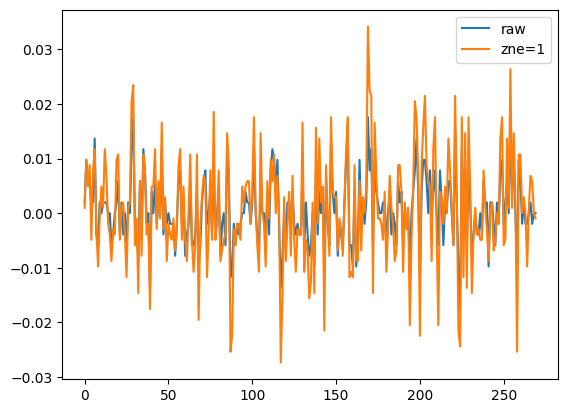

In [72]:
plt.plot(np.array(Z_list).imag,label='raw')
#plt.plot(np.array(Z_list_1).real,label='extrapo=1')
#plt.plot(np.array(Z_list_2).real, label='extrapo=2')
plt.plot(1.5*np.array(Z_list).imag-0.5*np.array(Z_list_1).imag,label='zne=1')
plt.legend()

In [185]:
len(Z_list)

270

In [32]:
ACDF = Assembly_ACDF(Z_list=Z_list,F_list=F_list_400[0:len(Z_list)],precision=10000)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


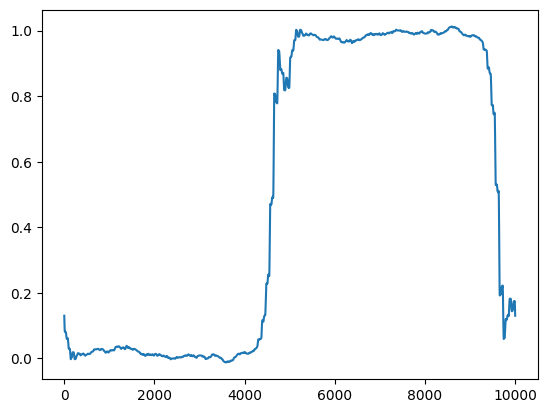

In [33]:
plt.plot(ACDF)